# UKAIRS 25 - experiments

## Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

from sksurv.datasets import load_gbsg2, load_whas500, load_aids
from sksurv.ensemble import RandomSurvivalForest
from sksurv.preprocessing import OneHotEncoder

import shap

/home/dmachlan/RDS/miniconda3/envs/ssp25/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## General purpose functions

In [5]:
def split_and_train(X, y, seed=20):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

    rsf = RandomSurvivalForest(
        n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=seed
    )

    rsf.fit(X_train, y_train)

    return rsf, (X_train, y_train), (X_test, y_test)

def get_feature_importances(model, X_test, y_test, seed=20):
    result = permutation_importance(model, X_test, y_test, n_repeats=15, random_state=seed)

    df = pd.DataFrame(
        {
            k: result[k]
            for k in (
                "importances_mean",
                "importances_std",
            )
        },
        index=X_test.columns,
    )

    return df.reset_index()

def get_explanations(model, X_test, eps):
    # compute the reference point (average patient)
    X_mean = X_test.mean().to_frame().T

    # find average risk
    y_mean = model.predict(X_mean)
    # predict risk for all
    y_pred = model.predict(X_test)

    # select only those individuals whose change in risk with respect to the reference point is smaller than epsilon (i.e. close to 0)
    sel_mask = np.abs(y_pred - y_mean) < eps

    # use the reference point
    ex = shap.KernelExplainer(model.predict, X_mean)

    # get SHAP values of the selected individuals (delta_R close to 0)
    return ex(X_test[sel_mask])

def make_plot(explanations, importances, columns, filename, figsize=(4, 3)):
    _, axs = plt.subplots(1, 2, figsize=figsize)

    ax = axs[0]
    for v in explanations.values:
        ax.scatter(v, columns, facecolors='none', edgecolors='g')

    ax.axvline(0.0, c='k', linewidth=0.5)
    ax.set_xlabel('SHAP value\n(ours)')
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax = axs[1]
    ax.scatter(importances['importances_mean'], importances['index'], facecolors='none', edgecolors='b')
    ax.set_yticks([]) # comment out to check if the features match with the first plot
    ax.axvline(0.0, c='k', linewidth=0.5)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('feature importance\n(baseline)')

    plt.tight_layout()
    plt.savefig(f'plots/{filename}.pdf', dpi=1000)

## GBSG 2

100%|██████████| 4/4 [00:02<00:00,  1.45it/s]


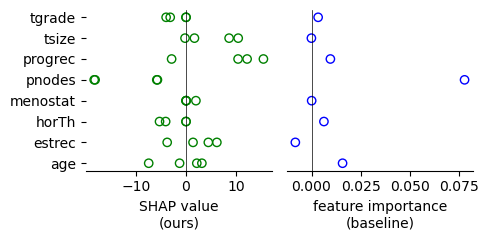

In [6]:
X, y = load_gbsg2()

grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis]
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade)
Xt.loc[:, "tgrade"] = grade_num

Xt.rename(columns={'horTh=yes': 'horTh', 'menostat=Post': 'menostat'}, inplace=True)

rsf, (X_train, y_train), (X_test, y_test) = split_and_train(Xt, y)

df = get_feature_importances(rsf, X_test, y_test)

ex_result = get_explanations(rsf, X_test, 1.0)

make_plot(ex_result, df, X_test.columns, 'gbsg2', (5, 2.5))

## AIDS

100%|██████████| 18/18 [00:10<00:00,  1.65it/s]


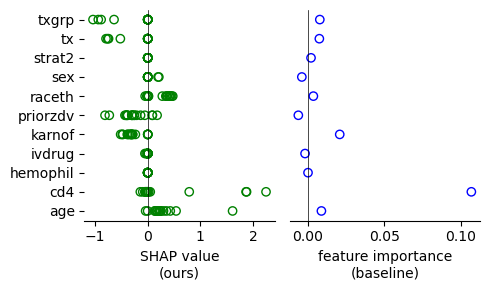

In [9]:
X, y = load_aids()

cat_cols = ['hemophil', 'ivdrug', 'karnof', 'raceth', 'sex', 'strat2', 'tx', 'txgrp']
X[cat_cols] = OrdinalEncoder().fit_transform(X[cat_cols])

rsf, (X_train, y_train), (X_test, y_test) = split_and_train(X, y)

df = get_feature_importances(rsf, X_test, y_test)

ex_result = get_explanations(rsf, X_test, 0.1)

make_plot(ex_result, df, X_test.columns, 'aids', (5, 3))

## WHAS 500

100%|██████████| 6/6 [00:04<00:00,  1.38it/s]


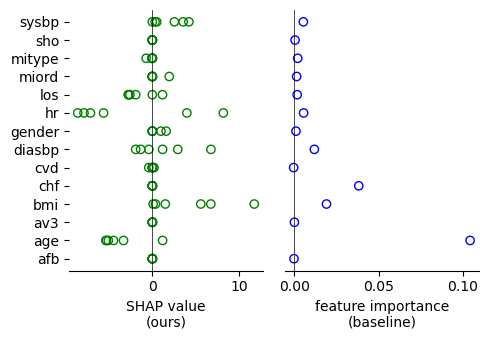

In [8]:
X, y = load_whas500()

cat_cols = ['afb', 'av3', 'chf', 'cvd', 'gender', 'miord', 'mitype', 'sho']
X[cat_cols] = OrdinalEncoder().fit_transform(X[cat_cols])

rsf, (X_train, y_train), (X_test, y_test) = split_and_train(X, y)

df = get_feature_importances(rsf, X_test, y_test)

ex_result = get_explanations(rsf, X_test, 1.0)

make_plot(ex_result, df, X_test.columns, 'whas500', (5, 3.5))